## The intersection experiment

## Data Preparation and Splitting for Training and Testing Sets

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),              # Convert NumPy array to PIL Image
    transforms.Resize((256, 256)),        # Resize to fixed dimensions (256x256)
    transforms.ToTensor(),                # Convert to Tensor
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale (mean=0.5, std=0.5)
])


# Dataset path and categories
dataset_dir = "Cropped_intersection_data"
categories = ['normal', 'benign', 'malignant']

# Load images and labels
images = []
labels = []

for category in categories:
    path = os.path.join(dataset_dir, category)
    class_num = categories.index(category)
    for img_name in os.listdir(path):
        if '_mask' not in img_name:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transform(img)  # Apply transformations
            images.append(img)
            labels.append(class_num)


# Convert lists to tensors
images_tensor = torch.stack(images)
labels_tensor = torch.tensor(labels)

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images_tensor, labels_tensor, test_size=0.2, random_state=random_seed, stratify=labels_tensor)


# # Split the dataset into training and validation sets
# train_size = int(0.8 * len(images_tensor))  # 80% for training
# val_size = len(images_tensor) - train_size  # 20% for validation
# train_dataset, val_dataset = random_split(TensorDataset(images_tensor, labels_tensor), [train_size, val_size])
# Create datasets
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Save the training and testing data into separate files for consistency
train_data_path = "train_data_Intersection.pt"
test_data_path = "test_data_Intersection.pt"
torch.save(train_dataset, train_data_path)
torch.save(test_dataset, test_data_path)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train data saved at: {train_data_path}")
print(f"Test data saved at: {test_data_path}")
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")



Train data saved at: /home/maryam.alshehyari/Documents/training/train_data_Intersection.pt
Test data saved at: /home/maryam.alshehyari/Documents/training/test_data_Intersection.pt
Training samples: 1061, Testing samples: 266


## Training and Validation of DenseNet12

In [ ]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split


# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Paths to the saved .pt files
train_data_path = "train_data_Intersection.pt"
test_data_path = "test_data_Intersection.pt"
# Load the pre-saved datasets
train_dataset = torch.load(train_data_path)
test_dataset = torch.load(test_data_path)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # No shuffling for validation

# Load the pre-trained DenseNet121 model
model = models.densenet121(pretrained=True)

# Modify the classifier for 3 classes
num_classes = 3
model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to track training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop with validation
num_epochs = 100  # Set the number of epochs
best_val = 0.0  
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Track the loss for this epoch
    correct_train = 0
    total_train = 0

    # Training phase
    for images, labels in train_loader:
        # Convert 1-channel grayscale images to 3-channel RGB
 
        images, labels = images.to(device), labels.to(device)  # Move data to the same device as model

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * images.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    validation_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            validation_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    # best_val = 0.0  # Initialize the best validation accuracy
    avg_val_loss = validation_loss / len(val_loader.dataset)
    accuracy = 100 * correct / total
    if accuracy > best_val:
        best_val = accuracy
        torch.save(model.state_dict(), "densenet121_ultrasound_intersection.pth")

    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Save the final model (optional)
# torch.save(model.state_dict(), "/home/maryam.alshehyari/Documents/training/densenet121_ultrasound.pth")
print(f"Best Validation Accuracy: {best_val:.2f}%")


/tmp/ipykernel_2732100/615987171.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(train_data_path)
/tmp/ipykernel_2732100/615987171.py:22: Fut

Epoch 1/100, Training Loss: 0.2356, Training Accuracy: 91.05%
Validation Loss: 0.2348, Accuracy: 93.61%
Epoch 2/100, Training Loss: 0.1097, Training Accuracy: 96.61%
Validation Loss: 0.1784, Accuracy: 95.11%
Epoch 3/100, Training Loss: 0.0979, Training Accuracy: 96.32%
Validation Loss: 0.2533, Accuracy: 94.36%
Epoch 4/100, Training Loss: 0.2032, Training Accuracy: 93.59%
Validation Loss: 0.1742, Accuracy: 96.62%
Epoch 5/100, Training Loss: 0.1023, Training Accuracy: 96.23%
Validation Loss: 0.9758, Accuracy: 60.90%
Epoch 6/100, Training Loss: 0.1068, Training Accuracy: 96.14%
Validation Loss: 0.7862, Accuracy: 88.35%
Epoch 7/100, Training Loss: 0.1608, Training Accuracy: 93.78%
Validation Loss: 0.6092, Accuracy: 58.27%
Epoch 8/100, Training Loss: 0.0563, Training Accuracy: 98.11%
Validation Loss: 0.2277, Accuracy: 94.74%
Epoch 9/100, Training Loss: 0.0546, Training Accuracy: 97.83%
Validation Loss: 0.1137, Accuracy: 96.24%
Epoch 10/100, Training Loss: 0.0256, Training Accuracy: 99.34%
V

## Visualizing Training and Validation Metrics for Model Performance

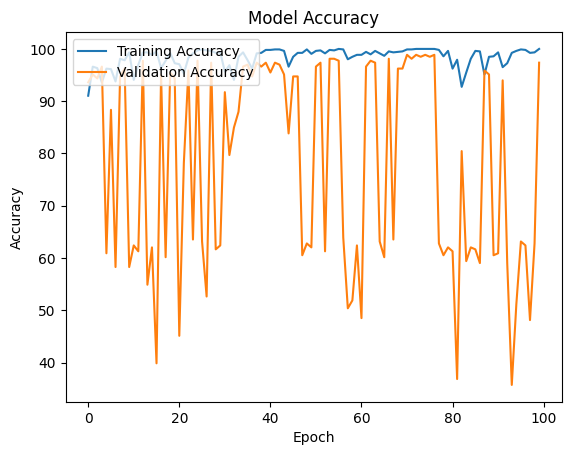

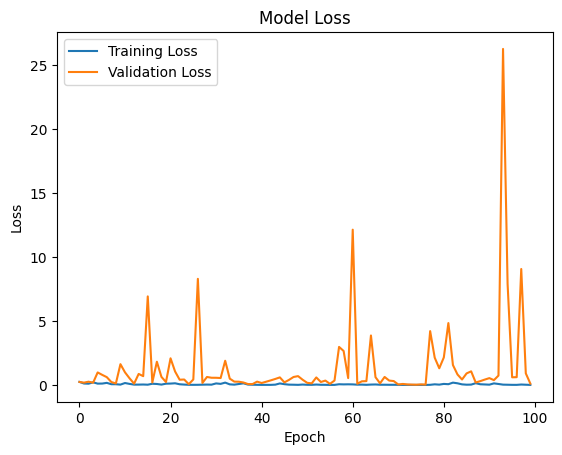

In [121]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
